# Выделение признаков и подготовка таблиц для обучения модели для рекомендации постов в социальной сети Karpov Courses.
Ноутбук выполнялся в kaggle.

In [1]:
!pip install psycopg2-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sqlalchemy import create_engine

from sklearn.utils import shuffle

import re
import string

from nltk.stem import WordNetLemmatizer
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import sys
import gc

from dotenv import load_dotenv
import os

In [3]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [5]:
# Загружаем доступы к базе данных соцальной сети Karpov Courses
load_dotenv(r'/kaggle/input/karpov-startml-db/env')

True

In [6]:
POSTGRESUSER = os.environ['POSTGRESUSER']
POSTGRES_PASSWORD = os.environ['POSTGRES_PASSWORD']
POSTGRES_HOST = os.environ['POSTGRES_HOST']
POSTGRES_PORT = os.environ['POSTGRES_PORT']
POSTGRES_DATABASE = os.environ['POSTGRES_DATABASE']

In [7]:
str_con_db = f'postgresql://{POSTGRESUSER}:{POSTGRES_PASSWORD}@{POSTGRES_HOST}:{POSTGRES_PORT}/{POSTGRES_DATABASE}'

In [8]:
engine = create_engine(str_con_db)

In [9]:
def load_feed_data(CHUNKSIZE: int = 1000000, limit:int = 1000, engine=engine) -> pd.DataFrame:
    """Выгрузка таблицы feed_data, по чанкам."""
    sql_text = "SELECT timestamp, user_id, post_id, target \
            FROM public.feed_data \
            WHERE action='view' \
            ORDER BY user_id, timestamp LIMIT {};"
    
    chunks = []
    conn = engine.connect().execution_options(stream_results=True)
    
    for indx, chunk_dataframe in enumerate(pd.read_sql(sql_text.format(limit), con=conn, chunksize=CHUNKSIZE)):
        chunks.append(chunk_dataframe)
        print(f'{indx} загрузка данных по чанкам {CHUNKSIZE}')
    
    conn.close()
    all_chunks = pd.concat(chunks, ignore_index=True)
    
    return all_chunks

In [10]:
def batch_load_sql(query: str, CHUNKSIZE: int = 1000000, engine=engine) -> pd.DataFrame:
    """Выполнение sql-запроса query и выгрузка результата, по чанкам."""
    conn = engine.connect().execution_options(stream_results=True)
    chunks = []
    for chunk_dataframe in pd.read_sql(query, conn, chunksize=CHUNKSIZE):
        chunks.append(chunk_dataframe)
    conn.close()
    return pd.concat(chunks, ignore_index=True)

# Таблица с пользователями.

In [11]:
user_info = pd.read_sql("""SELECT * FROM public.user_data""", con=engine)
user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [12]:
user_info.shape

(163205, 8)

Всего 163205 пользователей.

# Таблица с постами.

In [13]:
posts_info = pd.read_sql("""SELECT * FROM public.post_text_df""", con=engine)
posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [14]:
posts_info.shape

(7023, 3)

7023 постов.

# Таблица feed_data

Таблица очень большая, выгрузка всей таблицы приведёт к использованию всей оперативной памяти и падению ядра.

In [15]:
count_feed_data = pd.read_sql("""SELECT count(*) FROM public.feed_data""", con=engine)
count_feed_data.head()

,count
0,76892800


В таблице более 76 миллионов записей.

Таблица feed_data является основной таблицей для анализа постов, которые лайкают пользователи. Из условий задачи важны посты у которых в поле action == 'view' и поле target == 1. Загрузим 10_000_000 записей этой таблицы, где action == 'view', будем использовать специальную функцию, которая загружает данные частями, по чанкам, т.к. функция pd.read_sql при загрузке данных потребляет в 4 раза больше памяти.

In [16]:
feed_data_chunk = load_feed_data(limit = 10_000_000)

0 загрузка данных по чанкам 1000000
1 загрузка данных по чанкам 1000000
2 загрузка данных по чанкам 1000000
3 загрузка данных по чанкам 1000000
4 загрузка данных по чанкам 1000000
5 загрузка данных по чанкам 1000000
6 загрузка данных по чанкам 1000000
7 загрузка данных по чанкам 1000000
8 загрузка данных по чанкам 1000000
9 загрузка данных по чанкам 1000000


In [17]:
feed_data_chunk.target.value_counts()

0    8804157
1    1195843
Name: target, dtype: int64

Выборка не сбалансирована. Больше данных с target == 0. Сделаем выборку с примерно равным кол-вом target.

In [18]:
feed_data_1 = feed_data_chunk[feed_data_chunk.target == 1]
feed_data_0 = feed_data_chunk[feed_data_chunk.target == 0]

In [19]:
feed_data_0.shape

(8804157, 4)

In [20]:
# Выкинем часть данных с target == 0
frac =  feed_data_1.shape[0] / feed_data_0.shape[0] + 0.001
feed_data_0_lim = feed_data_0.sample(frac=frac)
feed_data_0_lim.shape

(1204647, 4)

In [21]:
# Объединим две выборки с target == 1 и target == 0 и перемешаем
feed_data_new = pd.concat([feed_data_0_lim, feed_data_1])
feed_data_new = shuffle(feed_data_new, random_state=0)

In [22]:
# Проверим сбалансированность выборки при её различном кол-ве 
feed_data_new.iloc[:100].target.value_counts()

0    51
1    49
Name: target, dtype: int64

In [23]:
feed_data_new.iloc[:1000].target.value_counts()

1    511
0    489
Name: target, dtype: int64

In [24]:
feed_data_new.iloc[:100000].target.value_counts()

0    50106
1    49894
Name: target, dtype: int64

In [25]:
feed_data_new.iloc[:1000000].target.value_counts()

0    501702
1    498298
Name: target, dtype: int64

In [26]:
feed_data_new.iloc[:10000000].target.value_counts()

0    1204647
1    1195843
Name: target, dtype: int64

In [27]:
# Сохраним выборку в csv-файл.
feed_data_new.to_csv('feed_data.csv', index=False)

In [28]:
# Очищаем память
del feed_data_new, feed_data_chunk, feed_data_1, feed_data_0, feed_data_0_lim
gc.collect()

42

# Выделение признаков пользователей.

In [29]:
user_info.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


Очевидно, что предпочтение постов пользователя не зависят от того какая операционная система на его устройстве и с какого ресурса он пришёл. Удалим эти признаки.

In [30]:
user_info_data = user_info.drop(['os', 'source'], axis=1)

Выделим новые признаки пользователей. Добавим колонки со средним значением лайка пользователя, каждого топика поста. Т.е. доля лайкнутых постов в каждом топике, для каждого пользователя. Выпорлним SQL запросом к БД.

In [31]:
sql_text = "SELECT public.feed_data.user_id, public.post_text_df.topic, avg(public.feed_data.target) \
            FROM public.feed_data \
            JOIN public.post_text_df ON public.feed_data.post_id=public.post_text_df.post_id \
            WHERE public.feed_data.action='view' \
            GROUP BY public.feed_data.user_id, public.post_text_df.topic;"

In [32]:
user_like = batch_load_sql(sql_text)

In [33]:
user_like

,user_id,topic,avg
0,200,business,0.071429
1,200,covid,0.096774
2,200,entertainment,0.285714
3,200,movie,0.170455
4,200,politics,0.068966
...,...,...,...
1142350,168552,entertainment,0.000000
1142351,168552,movie,0.039216
1142352,168552,politics,0.000000
1142353,168552,sport,0.185185


Преобразуем полученную таблицу в более удобный формат.

In [34]:
user_like = user_like.pivot_table('avg', index='user_id', columns='topic')

In [35]:
user_like

topic,business,covid,entertainment,movie,politics,sport,tech
user_id,,,,,,,
200,0.071429,0.096774,0.285714,0.170455,0.068966,0.109375,0.153846
201,0.103448,0.063953,0.121212,0.122677,0.013889,0.023256,0.137931
202,0.052632,0.139241,0.037037,0.126812,0.254237,0.168831,0.000000
203,0.157895,0.183099,0.181818,0.182482,0.200000,0.224490,0.222222
204,0.125000,0.258065,0.200000,0.140625,0.100000,0.117647,0.333333
...,...,...,...,...,...,...,...
168548,0.083333,0.072289,0.105263,0.047945,0.025641,0.000000,0.250000
168549,0.000000,0.074627,0.000000,0.063158,0.225806,0.160000,0.000000
168550,0.034483,0.117647,0.086957,0.135802,0.000000,0.030303,0.142857


In [36]:
user_like.columns.name = None
user_like = user_like.reset_index()

In [37]:
user_like

,user_id,business,covid,entertainment,movie,politics,sport,tech
0,200,0.071429,0.096774,0.285714,0.170455,0.068966,0.109375,0.153846
1,201,0.103448,0.063953,0.121212,0.122677,0.013889,0.023256,0.137931
2,202,0.052632,0.139241,0.037037,0.126812,0.254237,0.168831,0.000000
3,203,0.157895,0.183099,0.181818,0.182482,0.200000,0.224490,0.222222
4,204,0.125000,0.258065,0.200000,0.140625,0.100000,0.117647,0.333333
...,...,...,...,...,...,...,...,...
163200,168548,0.083333,0.072289,0.105263,0.047945,0.025641,0.000000,0.250000
163201,168549,0.000000,0.074627,0.000000,0.063158,0.225806,0.160000,0.000000
163202,168550,0.034483,0.117647,0.086957,0.135802,0.000000,0.030303,0.142857
163203,168551,0.047619,0.131148,0.176471,0.110000,0.026316,0.062500,0.066667


Данная таблица содержит значения nan. Они появились из-за того, что некоторые пользователи просто не смотрели, не интересовались постами определённых топиков.

In [38]:
user_like.isna().sum()

user_id           0
business          6
covid             0
entertainment    20
movie             0
politics          0
sport             0
tech             54
dtype: int64

In [39]:
# Заполним nan нулём
user_like.fillna(value=0, inplace=True)

In [40]:
user_like.isna().sum()

user_id          0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

In [41]:
# Объединим полученную таблицу с таблицей признаков пользователей
user_info_data = user_info_data.merge(user_like, left_on='user_id', right_on='user_id')

In [42]:
user_info_data

,user_id,gender,age,country,city,exp_group,business,covid,entertainment,movie,politics,sport,tech
0,200,1,34,Russia,Degtyarsk,3,0.071429,0.096774,0.285714,0.170455,0.068966,0.109375,0.153846
1,201,0,37,Russia,Abakan,0,0.103448,0.063953,0.121212,0.122677,0.013889,0.023256,0.137931
2,202,1,17,Russia,Smolensk,4,0.052632,0.139241,0.037037,0.126812,0.254237,0.168831,0.000000
3,203,0,18,Russia,Moscow,1,0.157895,0.183099,0.181818,0.182482,0.200000,0.224490,0.222222
4,204,0,36,Russia,Anzhero-Sudzhensk,3,0.125000,0.258065,0.200000,0.140625,0.100000,0.117647,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,0.083333,0.072289,0.105263,0.047945,0.025641,0.000000,0.250000
163201,168549,0,18,Russia,Tula,2,0.000000,0.074627,0.000000,0.063158,0.225806,0.160000,0.000000
163202,168550,1,41,Russia,Yekaterinburg,4,0.034483,0.117647,0.086957,0.135802,0.000000,0.030303,0.142857
163203,168551,0,38,Russia,Moscow,3,0.047619,0.131148,0.176471,0.110000,0.026316,0.062500,0.066667


In [43]:
# Ещё раз проверим на пустые значения
user_info_data.isna().sum()

user_id          0
gender           0
age              0
country          0
city             0
exp_group        0
business         0
covid            0
entertainment    0
movie            0
politics         0
sport            0
tech             0
dtype: int64

Проверим нет ли линейной зависимости от новых признаков пользователей.

<AxesSubplot:>

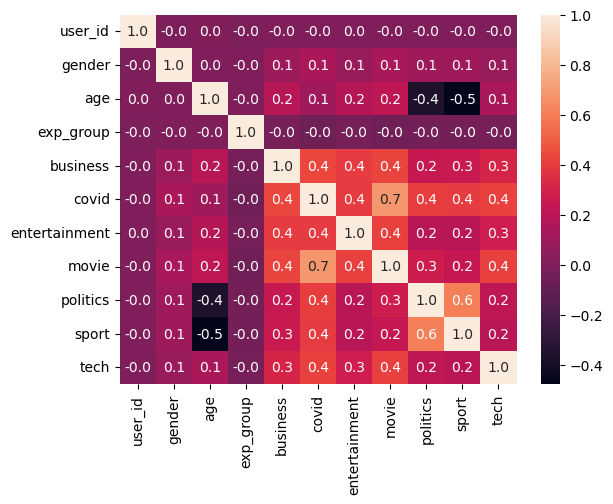

In [44]:
sns.heatmap(user_info_data.corr(method='pearson'), annot=True, fmt=".1f")

Есть заметная зависимость между covid и movie. И между politics и sport. Также присутствует умеренная обратная зависимость между age и sport. И есть довольно много умеренных зависимостей между новыми признаками. Уже по этим новым данным можно составить определённую картину пользователей. Например, те кому нравятся посты по теме политики, определённо предпочтут посты по спорту.

Запишем таблицу в БД.

In [45]:
user_info_data.to_sql('pavel55645_users_lesson_22', con=engine, if_exists='replace')

# Таблица с постами. Выделение признаков постов.

In [46]:
posts_info.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


Выполним лематизацию постов и преобразуем в tfidf.

In [47]:
wnl = WordNetLemmatizer()

def preprocessing(line: str, token=wnl) -> str:
    line = line.lower()
    line = re.sub(r'[{}]'.format(string.punctuation), ' ', line)
    line = line.replace(r'\n\n', ' ').replace(r'\n', ' ')
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')])
    return line

tfidf = TfidfVectorizer(stop_words='english', preprocessor=preprocessing)

In [48]:
tfidf_data = tfidf.fit_transform(posts_info['text']).toarray()

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'wa'] not in stop_words.
  % sorted(inconsistent)


In [49]:
tfidf_data

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.13279494, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.05136483, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [50]:
tfidf_data = pd.DataFrame(tfidf_data, index=posts_info.post_id, columns=tfidf.get_feature_names())

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [51]:
tfidf_data

,00,000,0001,000bn,000m,000s,000th,001,001and,001st,...,𝓫𝓮,𝓫𝓮𝓽𝓽𝓮𝓻,𝓬𝓸𝓾𝓻𝓽𝓼,𝓱𝓮𝓪𝓻𝓲𝓷𝓰,𝓶𝓪𝔂,𝓹𝓱𝔂𝓼𝓲𝓬𝓪𝓵,𝓼𝓸𝓸𝓷𝓮𝓻,𝓼𝓾𝓫𝓸𝓻𝓭𝓲𝓷𝓪𝓽𝓮,𝓽𝓱𝓮,𝓽𝓸
post_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.132795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.051365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7315,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7316,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7317,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Получилось слишком много признаков. Будем понижать размерность и кластеризовать посты.

In [52]:
posts_info_data = posts_info

In [53]:
# Создадим новые признаки постов на основе TfIdf
posts_info_data['TotalTfIdf'] = tfidf_data.sum(axis=1).reset_index()[0]
posts_info_data['MaxTfIdf'] = tfidf_data.max(axis=1).reset_index()[0]
posts_info_data['MeanTfIdf'] = tfidf_data.mean(axis=1).reset_index()[0]

In [54]:
posts_info_data.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.796359,0.494083,0.000189
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.909230,0.308132,0.000256
2,3,Asian quake hits European shares\n\nShares in ...,business,12.935175,0.200614,0.000278
3,4,India power shares jump on debut\n\nShares in ...,business,6.714893,0.542900,0.000144
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352120,0.420250,0.000137


Кластеризуем тексты. Для начала, при помощи PCA понизим размерность признаков tfidf

In [55]:
# Центруем значения tfidf
centered = tfidf_data - tfidf_data.mean()

In [56]:
del tfidf_data
gc.collect()

141

In [57]:
# Понижаем размерность признаков.
pca = PCA(n_components=20)
pca_decomp = pca.fit_transform(centered)

In [58]:
# Разделим тексты постов на 15 кластеров, при помощи метода к-средних. И для каждого поста вычислим расстояние для каждого кластера.
n_clusters = 15

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(pca_decomp)

# Добавляем признак метка кластера, для каждого поста.
posts_info_data['TextCluster'] = kmeans.labels_

dists_columns = [f"DistanceTo{ith}thCluster" for ith in range(1, n_clusters + 1)]

dists_df = pd.DataFrame(
    data=kmeans.transform(pca_decomp),
    columns=dists_columns
)

dists_df.head()

,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,DistanceTo4thCluster,DistanceTo5thCluster,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,0.439563,0.476647,0.525989,0.577732,0.448398,0.133566,0.454774,0.491698,0.384825,0.455664,0.528264,0.499950,0.543205,0.457611,0.427875
1,0.291927,0.341049,0.413877,0.332242,0.308124,0.270574,0.292754,0.363830,0.194770,0.321931,0.420314,0.374802,0.440154,0.307152,0.169212
2,0.306652,0.355077,0.427654,0.527312,0.326345,0.136852,0.334820,0.382879,0.206098,0.335009,0.439116,0.382722,0.471314,0.355046,0.327838
3,0.258363,0.316523,0.382000,0.486955,0.270908,0.240676,0.280283,0.313666,0.126942,0.304548,0.406651,0.348495,0.436034,0.317959,0.260532
4,0.177380,0.258599,0.343021,0.456168,0.194749,0.301233,0.238320,0.284530,0.065982,0.238080,0.398268,0.295108,0.396876,0.277128,0.219711


In [59]:
# Объединим все признаки постов.
posts_info_data = pd.concat((posts_info_data,dists_df), axis=1)
posts_info_data.head()

,post_id,text,topic,TotalTfIdf,MaxTfIdf,MeanTfIdf,TextCluster,DistanceTo1thCluster,DistanceTo2thCluster,DistanceTo3thCluster,...,DistanceTo6thCluster,DistanceTo7thCluster,DistanceTo8thCluster,DistanceTo9thCluster,DistanceTo10thCluster,DistanceTo11thCluster,DistanceTo12thCluster,DistanceTo13thCluster,DistanceTo14thCluster,DistanceTo15thCluster
0,1,UK economy facing major risks\n\nThe UK manufa...,business,8.796359,0.494083,0.000189,5,0.439563,0.476647,0.525989,...,0.133566,0.454774,0.491698,0.384825,0.455664,0.528264,0.499950,0.543205,0.457611,0.427875
1,2,Aids and climate top Davos agenda\n\nClimate c...,business,11.909230,0.308132,0.000256,14,0.291927,0.341049,0.413877,...,0.270574,0.292754,0.363830,0.194770,0.321931,0.420314,0.374802,0.440154,0.307152,0.169212
2,3,Asian quake hits European shares\n\nShares in ...,business,12.935175,0.200614,0.000278,5,0.306652,0.355077,0.427654,...,0.136852,0.334820,0.382879,0.206098,0.335009,0.439116,0.382722,0.471314,0.355046,0.327838
3,4,India power shares jump on debut\n\nShares in ...,business,6.714893,0.542900,0.000144,8,0.258363,0.316523,0.382000,...,0.240676,0.280283,0.313666,0.126942,0.304548,0.406651,0.348495,0.436034,0.317959,0.260532
4,5,Lacroix label bought by US firm\n\nLuxury good...,business,6.352120,0.420250,0.000137,8,0.177380,0.258599,0.343021,...,0.301233,0.238320,0.284530,0.065982,0.238080,0.398268,0.295108,0.396876,0.277128,0.219711


In [60]:
# Запишем признаки постов в таблицу БД.
posts_info_data.to_sql('pavel55645_posts_info_lesson_22', con=engine, if_exists='replace')

В итоге имеем выгрузку данных с таблицы feed_data и таблицы с признаками пользователей и постов, можно обучать модели.